# Air Quality Prediction Experiment

This notebook combines PWWB, AirNow, and HRRR datasets for air quality prediction using PyTorch.

# Experiment Configuration

In [2]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment

EXPERIMENT_NAME = "January Fire + HRRR"
EXPERIMENT_DESCRIPTION = "January 2025 fire period with PWWB, AirNow, and HRRR data"
EXPERIMENT_ID = "jan_fire_hrrr"

# Data parameters
START_DATE = "2025-01-01-00"
END_DATE = "2025-02-01-00"
TRAIN_SPLIT = 0.80  # 80% for training, 10% for val (will split later), leaving 20% for test.

# Model parameters
EPOCHS = 100
BATCH_SIZE = 4
WEIGHT_DECAY = 0.01

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: January Fire + HRRR
Description: January 2025 fire period with PWWB, AirNow, and HRRR data
Date Range: 2025-01-01-00 to 2025-02-01-00
Train/Test Split: 80%/20% (temporal)


# Data Parameters

In [3]:
# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 200
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 200x200
Frames per sample: 5


# PyTorch Setup and Dependencies

In [4]:
# Install PyTorch with RTX 5080 support
# Run this in terminal first:
# pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# pip install git+https://github.com/ndrplz/ConvLSTM_pytorch.git

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

# Check RTX 5080 compatibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    device = torch.device('cuda')
else:
    print("CUDA not available, using CPU")
    device = torch.device('cpu')

# Import ConvLSTM
try:
    from convlstm import ConvLSTM
    print("ConvLSTM imported successfully")
except ImportError:
    print("ConvLSTM not found. Install with: pip install git+https://github.com/ndrplz/ConvLSTM_pytorch.git")

PyTorch version: 2.8.0.dev20250526+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5080
CUDA version: 12.8
ConvLSTM imported successfully


# Data Ingestion and Preprocessing

In [5]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData

# Import the HRRR data class
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

# Temporal train-test split function
def temporal_train_test_split(X, Y, train_size=TRAIN_SPLIT):
    """Split data temporally - first portion for training, last portion for testing"""
    split_idx = int(X.shape[0] * train_size)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    Y_train = Y[:split_idx]
    Y_test = Y[split_idx:]
    
    print(f"Temporal split at index {split_idx}:")
    print(f"  Training: samples 0-{split_idx-1} ({train_size*100:.0f}% of time)")
    print(f"  Testing: samples {split_idx}-{len(X)-1} ({(1-train_size)*100:.0f}% of time)")
    
    return X_train, X_test, Y_train, Y_test

# Scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

/home/moh/miniconda3/envs/hysplitrevised/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file=f"{EXPERIMENT_ID}_registry.json",
    cache_dir="data/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Existing datasets:


,name,created,description,start_date,end_date,channels
0,jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV,2025-05-27T21:01:05.267706,"January 2025 fire period with PWWB, AirNow, an...",2025-01-01-00,2025-02-01-00,"maiac, tropomi, metar"


In [7]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = f"{EXPERIMENT_ID}_MAIAC_TROPOMI_NO2_METAR_WIND_UV"
dataset_desc = f"{EXPERIMENT_DESCRIPTION} - MAIAC, TROPOMI NO2, METAR Wind U/V components"

# ========== 1. Load PWWB Data ==========
print(f"\nLoading PWWB data for {EXPERIMENT_NAME}...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    pwwb_data = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    pwwb_data = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=START_DATE,
        end_date=END_DATE,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': True,                     # Include MAIAC AOD
            'tropomi': ['TROPOMI_NO2'],        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    pwwb_data.save_data()

# Get the data and channel info
X_pwwb = pwwb_data.data
channel_info = pwwb_data.get_channel_info()
print(f"✓ PWWB data shape: {X_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")

# ========== 2. Load AirNow Data ==========
print(f"\nLoading AirNow data for {EXPERIMENT_NAME}...")
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
else:
    print("  No target stations available")

# ========== 3. Load HRRR Data ==========
print(f"\nLoading HRRR data for {EXPERIMENT_NAME}...")
hrrr_data = HRRRData(
    start_date=START_DATE,
    end_date=END_DATE,
    extent=extent,
    extent_name='la_region',
    product='COLMD',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True,
    sample_setting=2
)
X_hrrr = hrrr_data.data
print(f"✓ HRRR data shape: {X_hrrr.shape}")


Loading PWWB data for January Fire + HRRR...
Dataset 'jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV' already exists, loading from cache...
Using cache prefix: jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_
Initialized PWWBData with 744 hourly timestamps
Date range: 2025-01-01 00:00:00 to 2025-01-31 23:00:00
Channels included: ['maiac', 'tropomi', 'metar']
TROPOMI channels: ['TROPOMI_NO2']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing MAIAC AOD data...
Loading cached MAIAC AOD data from data/pwwb_cache/jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_maiac_aod_data.npy
Processing TROPOMI data...
Including TROPOMI channels: ['TROPOMI_NO2']
Loading cached TROPOMI data from data/pwwb_cache/jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_tropomi_no2_data.npy


/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/pwwb_data.py:115: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.timestamps = pd.date_range(self.start_date, self.end_date, freq='H')


Processing METAR meteorological data...
Initialized MetarDataSource with 2 channels: ['METAR_Wind_U', 'METAR_Wind_V']
Will fetch these raw variables: ['sped', 'drct']
Will calculate wind U/V components from speed/direction
Loading cached data from data/pwwb_cache/jan_fire_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_metar_u_v_data.npy
Final data shape: (740, 5, 200, 200, 4)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: 0.0
  Max: 0.8014171123504639
  Mean: 0.10838194690956557
  Std: 0.06557607657251029
  Data coverage: 99.90% (39961/40000 non-zero pixels)

Channel 1: TROPOMI_NO2
  Min: 1.4838944118541255e-05
  Max: 0.00037769780169348766
  Mean: 0.000111128405008148
  Std: 6.189170878602218e-05
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 2: METAR_Wind_U
  Min: -4.530115663856156
  Max: 10.192760243676352
  Mean: 2.8403127391134904
  Std: 1.6066684413880397
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 3: METAR_Wind_V
  Min: -1.198172425901817
  Max: 4.

In [8]:
# ========== 4. Create Combined Dataset ==========
print(f"\nCreating combined dataset for {EXPERIMENT_NAME}...")

# Combine all data sources
X_combined = np.concatenate([X_pwwb, X_airnow, X_hrrr], axis=-1)
print(f"Combined data shape: {X_combined.shape}")

# Display the number of channels from each source
pwwb_channels = X_pwwb.shape[4]
airnow_channels = X_airnow.shape[4]
hrrr_channels = X_hrrr.shape[4]
total_channels = X_combined.shape[4]

print(f"Channel breakdown:")
print(f"  PWWB: {pwwb_channels} channels")
print(f"  AirNow: {airnow_channels} channels")
print(f"  HRRR: {hrrr_channels} channels")
print(f"  Total: {total_channels} channels")

# Create combined channel names
all_channel_names = channel_info['channel_names'] + ["AirNow_PM25"] + ["HRRR_COLMD"]
print(f"  Channel names: {all_channel_names}")


Creating combined dataset for January Fire + HRRR...
Combined data shape: (740, 5, 200, 200, 6)
Channel breakdown:
  PWWB: 4 channels
  AirNow: 1 channels
  HRRR: 1 channels
  Total: 6 channels
  Channel names: ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25', 'HRRR_COLMD']


In [9]:
# ========== 5. Temporal Train/Test Split ==========
print(f"\nCreating temporal train/test split for {EXPERIMENT_NAME}...")

# Temporal split preserving time sequence
X_train, X_test, Y_train, Y_test = temporal_train_test_split(
    X_combined, Y_targets, train_size=TRAIN_SPLIT
)

print(f"✓ Train shapes: X={X_train.shape}, Y={Y_train.shape}")
print(f"✓ Test shapes: X={X_test.shape}, Y={Y_test.shape}")


Creating temporal train/test split for January Fire + HRRR...
Temporal split at index 592:
  Training: samples 0-591 (80% of time)
  Testing: samples 592-739 (20% of time)
✓ Train shapes: X=(592, 5, 200, 200, 6), Y=(592, 10)
✓ Test shapes: X=(148, 5, 200, 200, 6), Y=(148, 10)


In [10]:
# ========== 6. Standardize Data ==========
print(f"\nStandardizing data for {EXPERIMENT_NAME}...")

X_train_scaled, X_test_scaled = std_scale(X_train, X_test)
print(f"✓ Scaled train shape: {X_train_scaled.shape}")
print(f"✓ Scaled test shape: {X_test_scaled.shape}")


Standardizing data for January Fire + HRRR...
✓ Scaled train shape: (592, 5, 200, 200, 6)
✓ Scaled test shape: (148, 5, 200, 200, 6)


In [11]:
# ========== 7. Save Prepared Datasets ==========
print(f"\nSaving prepared dataset for {EXPERIMENT_NAME}...")

# Save training and test data
np.save(os.path.join(output_dir, "X_train.npy"), X_train_scaled)
np.save(os.path.join(output_dir, "X_test.npy"), X_test_scaled)
np.save(os.path.join(output_dir, "Y_train.npy"), Y_train)
np.save(os.path.join(output_dir, "Y_test.npy"), Y_test)

# Save metadata
metadata = {
    "experiment_name": EXPERIMENT_NAME,
    "experiment_description": EXPERIMENT_DESCRIPTION,
    "experiment_id": EXPERIMENT_ID,
    "framework": "PyTorch",
    "date_range": f"{START_DATE} to {END_DATE}",
    "train_split": TRAIN_SPLIT,
    "extent": extent,
    "dim": dim,
    "frames_per_sample": frames_per_sample,
    "total_samples": len(X_combined),
    "train_samples": len(X_train),
    "test_samples": len(X_test),
    "channel_breakdown": {
        "pwwb_channels": pwwb_channels,
        "airnow_channels": airnow_channels,
        "hrrr_channels": hrrr_channels,
        "total_channels": total_channels
    },
    "channel_names": all_channel_names,
    "sensor_count": len(airnow_data.air_sens_loc),
    "sensor_names": list(airnow_data.air_sens_loc.keys())
}

with open(os.path.join(output_dir, "metadata.json"), "w") as f:
    import json
    json.dump(metadata, f, indent=2)

print(f"✓ Dataset prepared and saved to: {output_dir}")


Saving prepared dataset for January Fire + HRRR...
✓ Dataset prepared and saved to: experiment_output/jan_fire_hrrr


In [12]:
# # Comprehensive data quality check
# import numpy as np
# import torch

# def check_data_quality(X_train_scaled, X_test_scaled, Y_train, Y_test, channel_names):
#     """Comprehensive data quality check"""
    
#     print("=" * 60)
#     print("DATA QUALITY DIAGNOSTIC")
#     print("=" * 60)
    
#     # Check for NaN/Inf in training data
#     print("\n1. CHECKING FOR NaN/Inf VALUES")
#     print("-" * 40)
    
#     datasets = {
#         "X_train_scaled": X_train_scaled,
#         "X_test_scaled": X_test_scaled, 
#         "Y_train": Y_train,
#         "Y_test": Y_test
#     }
    
#     for name, data in datasets.items():
#         nan_count = np.isnan(data).sum()
#         inf_count = np.isinf(data).sum()
#         total_elements = data.size
        
#         print(f"{name}:")
#         print(f"  Shape: {data.shape}")
#         print(f"  NaN values: {nan_count:,} ({100*nan_count/total_elements:.3f}%)")
#         print(f"  Inf values: {inf_count:,} ({100*inf_count/total_elements:.3f}%)")
#         print(f"  Min: {np.nanmin(data):.6f}")
#         print(f"  Max: {np.nanmax(data):.6f}")
#         print(f"  Mean: {np.nanmean(data):.6f}")
#         print(f"  Std: {np.nanstd(data):.6f}")
#         print()
    
#     # Check each channel separately
#     print("2. CHANNEL-BY-CHANNEL ANALYSIS")
#     print("-" * 40)
    
#     for i, channel_name in enumerate(channel_names):
#         channel_data = X_train_scaled[:, :, :, :, i]
#         nan_count = np.isnan(channel_data).sum()
#         inf_count = np.isinf(channel_data).sum()
#         total_elements = channel_data.size
        
#         print(f"Channel {i} ({channel_name}):")
#         print(f"  NaN: {nan_count:,} ({100*nan_count/total_elements:.3f}%)")
#         print(f"  Inf: {inf_count:,} ({100*inf_count/total_elements:.3f}%)")
#         print(f"  Range: [{np.nanmin(channel_data):.6f}, {np.nanmax(channel_data):.6f}]")
#         print(f"  Mean ± Std: {np.nanmean(channel_data):.6f} ± {np.nanstd(channel_data):.6f}")
        
#         # Check for extreme values
#         extreme_threshold = 10
#         extreme_count = np.sum(np.abs(channel_data) > extreme_threshold)
#         print(f"  Values > |{extreme_threshold}|: {extreme_count:,}")
#         print()
    
#     # Check target values
#     print("3. TARGET VALUE ANALYSIS")
#     print("-" * 40)
    
#     for sensor_idx in range(Y_train.shape[1]):
#         sensor_data = Y_train[:, sensor_idx]
#         nan_count = np.isnan(sensor_data).sum()
#         print(f"Sensor {sensor_idx}:")
#         print(f"  NaN: {nan_count} ({100*nan_count/len(sensor_data):.1f}%)")
#         print(f"  Range: [{np.nanmin(sensor_data):.2f}, {np.nanmax(sensor_data):.2f}]")
#         print(f"  Mean: {np.nanmean(sensor_data):.2f}")
    
#     # Check for potential standardization issues
#     print("\n4. STANDARDIZATION CHECK")
#     print("-" * 40)
    
#     # Look for channels that might not be properly standardized
#     for i, channel_name in enumerate(channel_names):
#         channel_data = X_train_scaled[:, :, :, :, i]
#         channel_mean = np.nanmean(channel_data)
#         channel_std = np.nanstd(channel_data)
        
#         print(f"{channel_name}:")
#         print(f"  Mean: {channel_mean:.6f} (should be ~0)")
#         print(f"  Std: {channel_std:.6f} (should be ~1)")
        
#         if abs(channel_mean) > 0.1:
#             print(f"  ⚠️  WARNING: Mean far from 0!")
#         if abs(channel_std - 1.0) > 0.5:
#             print(f"  ⚠️  WARNING: Std far from 1!")
#         print()
    
#     # PyTorch tensor check
#     print("5. PYTORCH TENSOR CHECK")
#     print("-" * 40)
    
#     try:
#         X_train_torch = torch.FloatTensor(X_train_scaled)
#         Y_train_torch = torch.FloatTensor(Y_train)
        
#         print(f"PyTorch X_train:")
#         print(f"  Has NaN: {torch.isnan(X_train_torch).any()}")
#         print(f"  Has Inf: {torch.isinf(X_train_torch).any()}")
#         print(f"  Min: {X_train_torch.min().item():.6f}")
#         print(f"  Max: {X_train_torch.max().item():.6f}")
        
#         print(f"PyTorch Y_train:")
#         print(f"  Has NaN: {torch.isnan(Y_train_torch).any()}")
#         print(f"  Has Inf: {torch.isinf(Y_train_torch).any()}")
#         print(f"  Min: {Y_train_torch.min().item():.6f}")
#         print(f"  Max: {Y_train_torch.max().item():.6f}")
        
#     except Exception as e:
#         print(f"❌ Error creating PyTorch tensors: {e}")
    
#     print("\n" + "=" * 60)
#     print("RECOMMENDATIONS:")
#     print("=" * 60)
    
#     # Generate recommendations based on findings
#     total_nan = sum(np.isnan(data).sum() for data in datasets.values())
#     total_inf = sum(np.isinf(data).sum() for data in datasets.values())
    
#     if total_nan > 0:
#         print("🔴 NaN values detected - this WILL cause training to fail!")
#         print("   Solutions: Replace NaN with 0, mean imputation, or remove affected samples")
    
#     if total_inf > 0:
#         print("🔴 Infinite values detected - this WILL cause training to fail!")
#         print("   Solutions: Clip extreme values or re-examine data preprocessing")
    
#     # Check for standardization issues
#     badly_standardized = []
#     for i, channel_name in enumerate(channel_names):
#         channel_data = X_train_scaled[:, :, :, :, i]
#         channel_mean = np.nanmean(channel_data)
#         channel_std = np.nanstd(channel_data)
        
#         if abs(channel_mean) > 0.1 or abs(channel_std - 1.0) > 0.5:
#             badly_standardized.append(channel_name)
    
#     if badly_standardized:
#         print(f"🟡 Poor standardization in: {badly_standardized}")
#         print("   This might contribute to training instability")
    
#     if total_nan == 0 and total_inf == 0:
#         print("✅ No NaN/Inf values found - data quality looks good!")
#         print("   NaN issue is likely in model architecture (probably BatchNorm)")

# # Run the diagnostic
# print("Running comprehensive data quality check...")
# check_data_quality(X_train_scaled, X_test_scaled, Y_train, Y_test, all_channel_names)

# Data Visualization

Visualizing data for January Fire + HRRR...


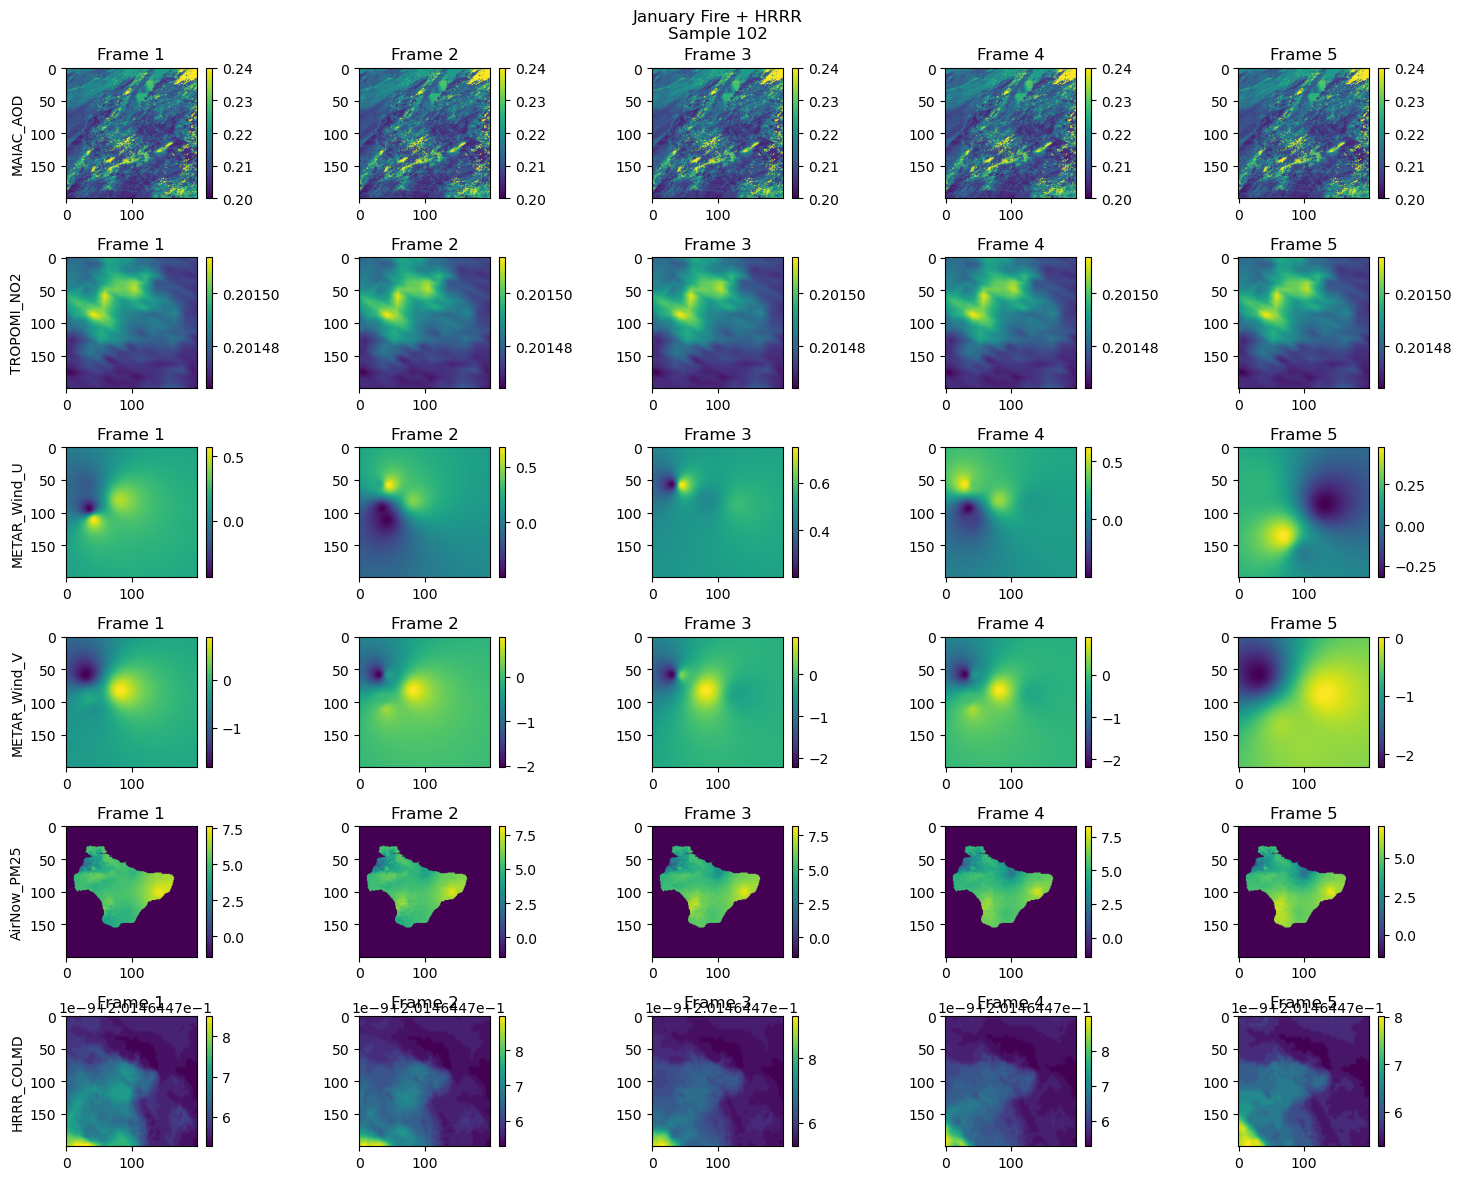

Target values: [ 2.2 22.2 24.2 42.2 35.7 28.3  3.  45.4 25.1 27.2]


In [21]:
# Function to visualize data from experiment
def visualize_experiment_data(X, Y, channel_names=None, sample_idx=None, experiment_name="Experiment"):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        channel_name = channel_names[c] if c < len(channel_names) else f"Channel {c}"
        
        for f in range(n_frames):
            ax = axes[c, f]
            data = X[sample_idx, f, :, :, c]
            
            # Special vmin/vmax for MAIAC to show variation better
            if 'MAIAC' in channel_name:
                # Use a narrow range centered on your actual data (around 0.21-0.22)
                im = ax.imshow(data, vmin=0.20, vmax=0.24)  # Focus on your actual data range
            else:
                im = ax.imshow(data)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_name)
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"{experiment_name}\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if Y is not None:
        print(f"Target values: {Y[sample_idx]}")

# Run the visualization  
print(f"Visualizing data for {EXPERIMENT_NAME}...")
visualize_experiment_data(X_train_scaled, Y_train, channel_names=all_channel_names, experiment_name=EXPERIMENT_NAME)

# PyTorch Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from convlstm import ConvLSTM

class PollutantPredictionModel(nn.Module):
    def __init__(self, input_shape, output_size):
        """
        PyTorch air quality prediction model
        input_shape: (timesteps, height, width, channels) - from X_train_scaled.shape[1:]
        output_size: number of output features - from Y_train.shape[1]
        """
        super(PollutantPredictionModel, self).__init__()
        
        timesteps, height, width, channels = input_shape
        
        # ConvLSTM layers
        self.convlstm = ConvLSTM(
            input_dim=channels,        # Input channels
            hidden_dim=[15, 30],       # Hidden dimensions for each layer
            kernel_size=(3, 3),        # Kernel size
            num_layers=2,              # Number of ConvLSTM layers
            batch_first=True,          # (batch, time, channel, height, width)
            bias=True,
            return_all_layers=False    # Only return final layer output
        )
        
        # Conv3D layers with BatchNorm
        self.conv3d_1 = nn.Conv3d(
            in_channels=30,            # From ConvLSTM output
            out_channels=15,           # Output channels
            kernel_size=(3, 3, 3),     # 3D kernel
            padding=1                  # Same padding
        )
        self.bn1 = nn.BatchNorm3d(15)  # Batch normalization
        self.relu1 = nn.ReLU()
        
        self.conv3d_2 = nn.Conv3d(
            in_channels=15,            # From previous layer
            out_channels=1,            # Final single channel
            kernel_size=(3, 3, 3),     # 3D kernel
            padding=1                  # Same padding
        )
        self.bn2 = nn.BatchNorm3d(1)   # Batch normalization
        self.relu2 = nn.ReLU()
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout3d(0.3)  # After ConvLSTM
        self.dropout2 = nn.Dropout(0.4)    # Before final dense layer
        
        # Calculate flattened size dynamically
        self.flatten_size = self._get_flatten_size(timesteps, height, width, channels)
        
        # Dense layers with regularization
        self.fc1 = nn.Linear(self.flatten_size, 128)  # Intermediate layer
        self.fc1_dropout = nn.Dropout(0.3)
        self.fc1_relu = nn.ReLU()
        
        self.fc2 = nn.Linear(128, output_size)        # Final output layer
        
    def _get_flatten_size(self, timesteps, height, width, channels):
        """Calculate the size after ConvLSTM and Conv3D layers"""
        dummy_input = torch.zeros(1, timesteps, channels, height, width)
        with torch.no_grad():
            x = self.forward_features(dummy_input)
            return x.view(1, -1).size(1)
    
    def forward_features(self, x):
        """Forward pass through ConvLSTM and Conv3D layers"""
        # ConvLSTM forward
        layer_output_list, _ = self.convlstm(x)
        
        # Handle list output
        if isinstance(layer_output_list, list):
            convlstm_out = layer_output_list[0]
        else:
            convlstm_out = layer_output_list
        
        # Permute for Conv3D: (batch, channels, timesteps, height, width)
        x = convlstm_out.permute(0, 2, 1, 3, 4)
        
        # Apply dropout
        x = self.dropout1(x)
        
        # Conv3D layers with batch normalization
        x = self.conv3d_1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv3d_2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        return x
    
    def forward(self, x):
        # Feature extraction
        x = self.forward_features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layers with regularization
        x = self.fc1(x)
        x = self.fc1_dropout(x)
        x = self.fc1_relu(x)
        
        x = self.fc2(x)
        
        return x

def prepare_pytorch_data(X, Y):
    """Convert numpy arrays to PyTorch tensors and permute dimensions"""
    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.FloatTensor(Y)
    
    # Permute from (batch, timesteps, height, width, channels) to
    # (batch, timesteps, channels, height, width) for ConvLSTM
    X_tensor = X_tensor.permute(0, 1, 4, 2, 3)
    
    return X_tensor, Y_tensor

def train_pytorch_model(model, train_loader, val_loader, epochs=100, device='cuda', lr=1e-4):
    """Simplified training function"""
    model.to(device)
    criterion = nn.L1Loss()  # Mean Absolute Error (same as Keras)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Simple Adam, no weight decay
    
    # Training history
    train_losses = []
    val_losses = []
    
    print(f"Training model on {device} with Adam (lr={lr})...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return {'loss': train_losses, 'val_loss': val_losses}

# Model Training

In [ ]:
print(f"\n==== Training Model for {EXPERIMENT_NAME} ====")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Target data shape: {Y_train.shape}")

X_train_torch, Y_train_torch = prepare_pytorch_data(X_train_scaled, Y_train)
X_test_torch, Y_test_torch = prepare_pytorch_data(X_test_scaled, Y_test)

print(f"PyTorch training data shape: {X_train_torch.shape}")
print(f"PyTorch target data shape: {Y_train_torch.shape}")

input_shape = X_train_scaled.shape[1:]  # (timesteps, height, width, channels)
output_size = Y_train.shape[1]
model = PollutantPredictionModel(input_shape, output_size)

print(f"\nModel Architecture for {EXPERIMENT_NAME}:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

train_dataset = TensorDataset(X_train_torch, Y_train_torch)

train_size = int(0.8 * len(train_dataset))  # 80% for training, 20% for validation
train_subset = Subset(train_dataset, range(train_size))
val_subset = Subset(train_dataset, range(train_size, len(train_dataset)))

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_torch, Y_test_torch), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"\nTraining for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
history = train_pytorch_model(
    model, train_loader, val_loader, 
    epochs=EPOCHS, 
    device=device, 
)
print(f"\n✓ Model training completed for {EXPERIMENT_NAME}!")



==== Training Model for January Fire + HRRR ====
Training data shape: (592, 5, 200, 200, 6)
Target data shape: (592, 10)
PyTorch training data shape: torch.Size([592, 5, 6, 200, 200])
PyTorch target data shape: torch.Size([592, 10])

Model Architecture for January Fire + HRRR:
PollutantPredictionModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(21, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(45, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv3d_1): Conv3d(30, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3d_2): Conv3d(15, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout1

# Model Evaluation


Evaluating model for January Fire + HRRR...
Test MAE: 2.7296

Final Results for January Fire + HRRR:
Mean Absolute Error: 2.7296
Root Mean Squared Error: 4.5966
R² Score: 0.5376


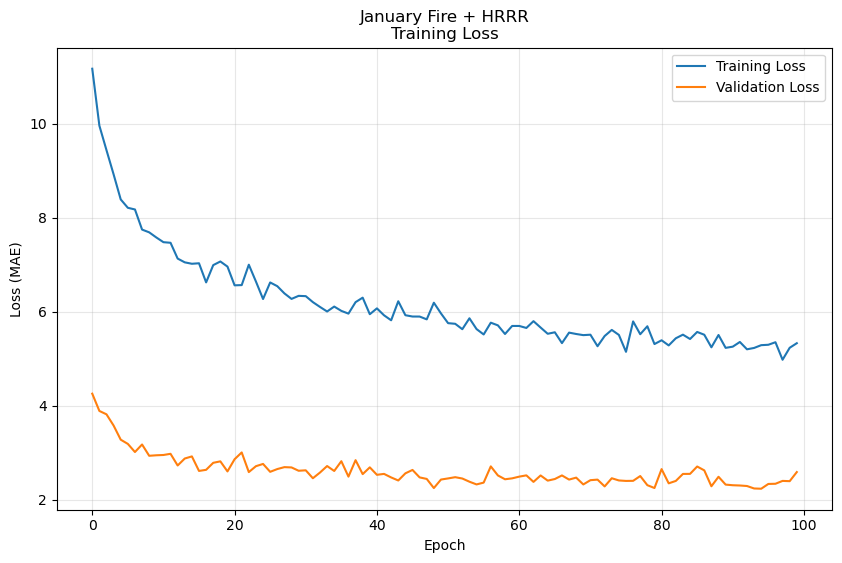


✓ Evaluation completed for January Fire + HRRR


In [24]:
# Evaluate model
print(f"\nEvaluating model for {EXPERIMENT_NAME}...")
model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        
        # Calculate loss
        criterion = nn.L1Loss()
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        # Store predictions and actuals
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test MAE: {test_loss:.4f}")

# Convert to numpy arrays
y_pred = np.array(predictions)
y_actual = np.array(actuals)

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nFinal Results for {EXPERIMENT_NAME}:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{EXPERIMENT_NAME}\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
np.save(os.path.join(results_dir, "y_actual.npy"), y_actual)
torch.save(model.state_dict(), os.path.join(results_dir, "model.pth"))
torch.save({
    'model_state_dict': model.state_dict(),
    'input_shape': input_shape,
    'output_size': output_size,
    'history': history,
    'experiment_config': {
        'name': EXPERIMENT_NAME,
        'description': EXPERIMENT_DESCRIPTION,
        'id': EXPERIMENT_ID
    }
}, os.path.join(results_dir, "checkpoint.pth"))

# Results dictionary
experiment_results = {
    'experiment_name': EXPERIMENT_NAME,
    'model': model,
    'history': history,
    'test_loss': test_loss,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'y_pred': y_pred,
    'y_actual': y_actual
}

print(f"\n✓ Evaluation completed for {EXPERIMENT_NAME}")

# Detailed Analysis

In [25]:
print(f"\nDetailed analysis for {EXPERIMENT_NAME}:")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Temporal split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}%")
print(f"Total sensors: {len(airnow_data.air_sens_loc)}")


Detailed analysis for January Fire + HRRR:
Description: January 2025 fire period with PWWB, AirNow, and HRRR data
Date range: 2025-01-01-00 to 2025-02-01-00
Temporal split: 80%/20%
Total sensors: 10



Sensors in January Fire + HRRR: ['Reseda', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 'Fontana - Arrow Highway', 'Riverside - Rubidoux']

1. Plotting prediction comparison...


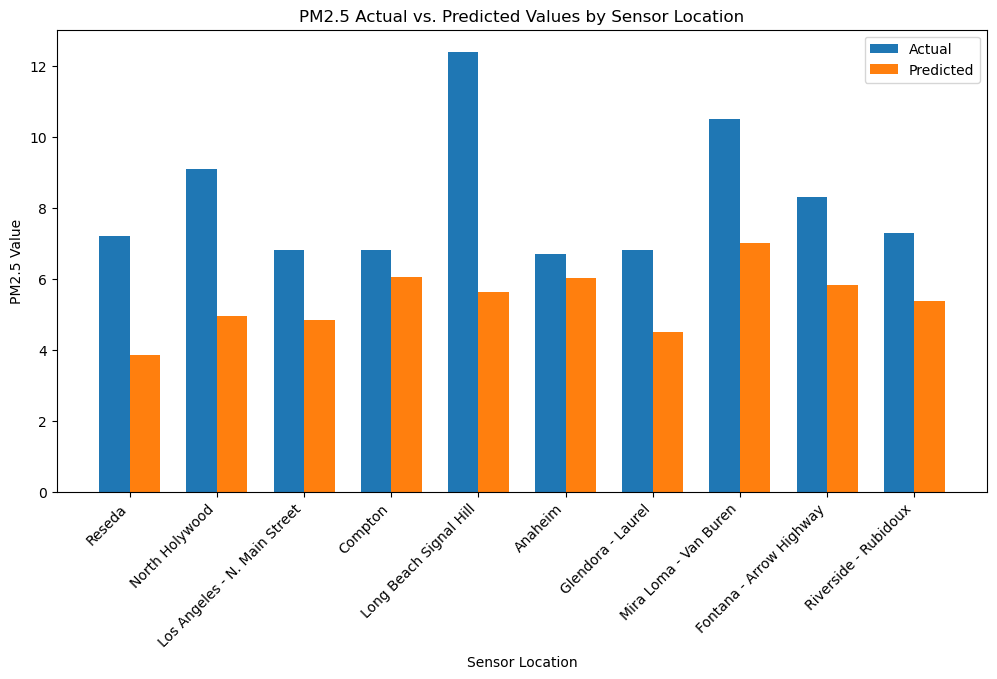


2. Plotting scatter comparison...


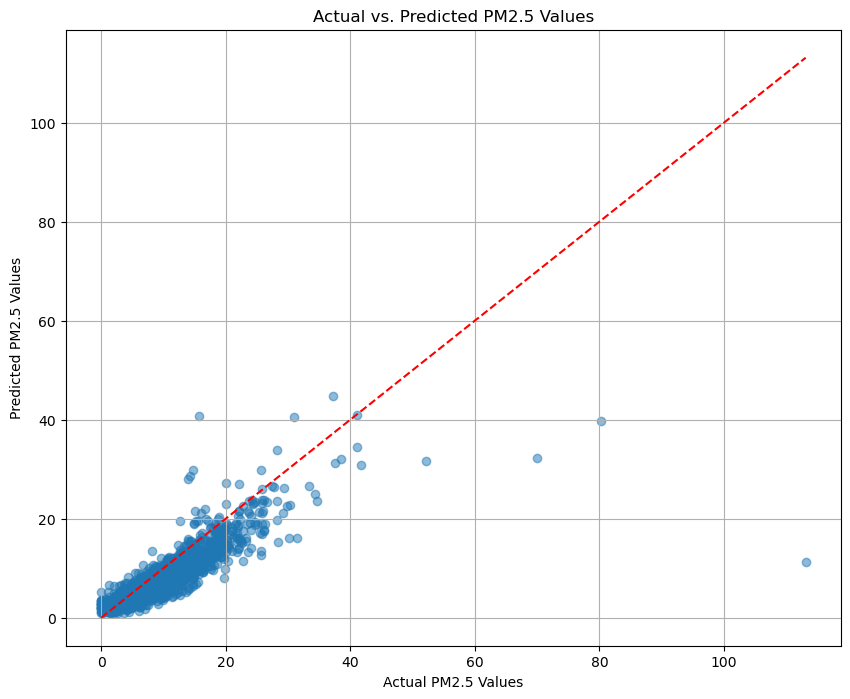


3. Plotting error by sensor...


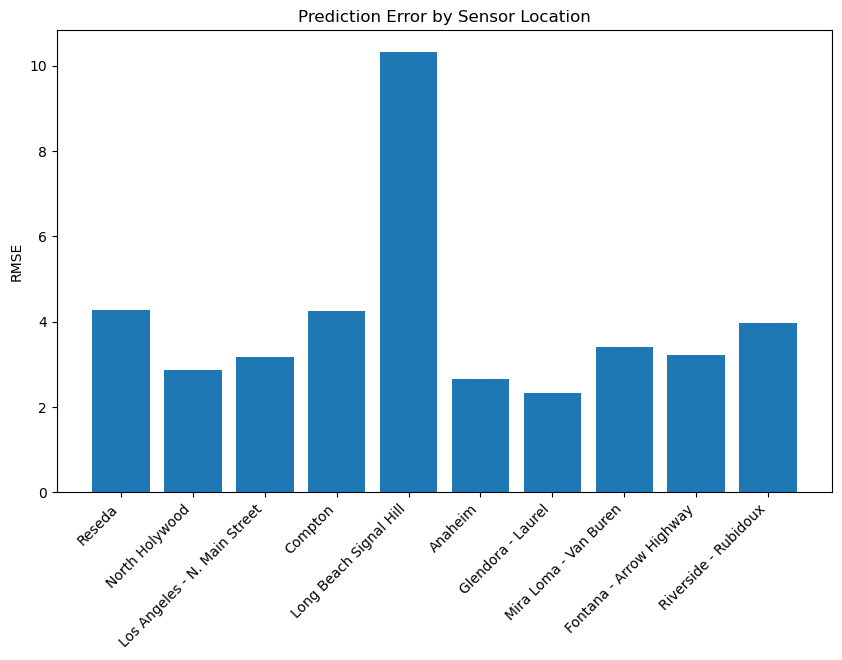


4. Plotting time series comparison...


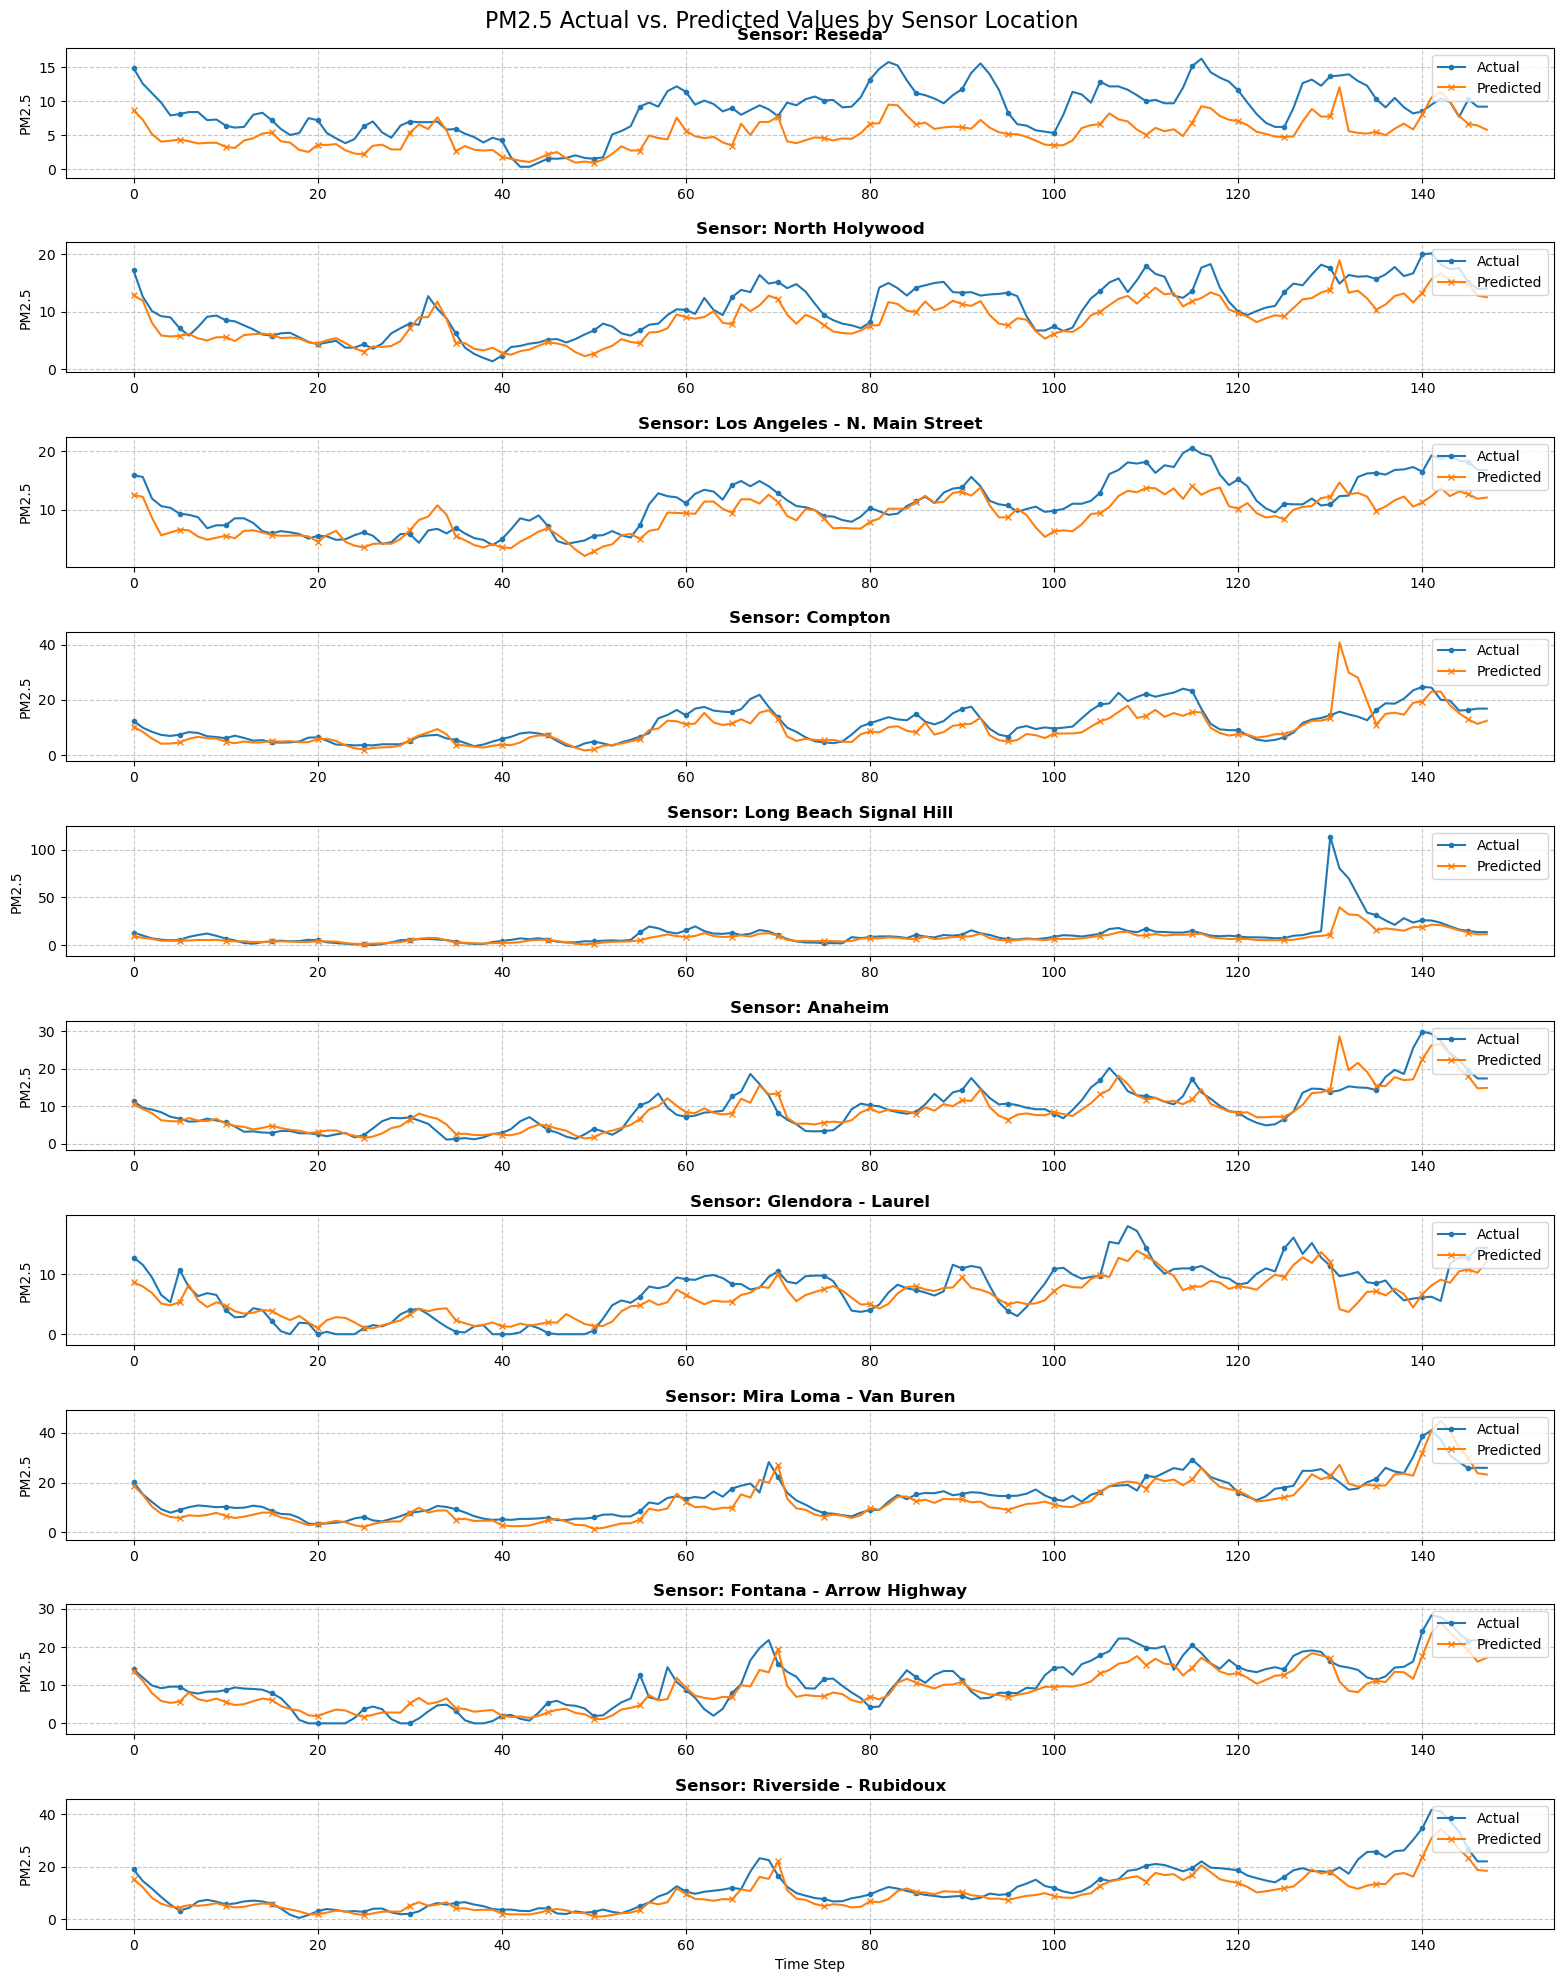


5. Plotting time series with shifted predictions...


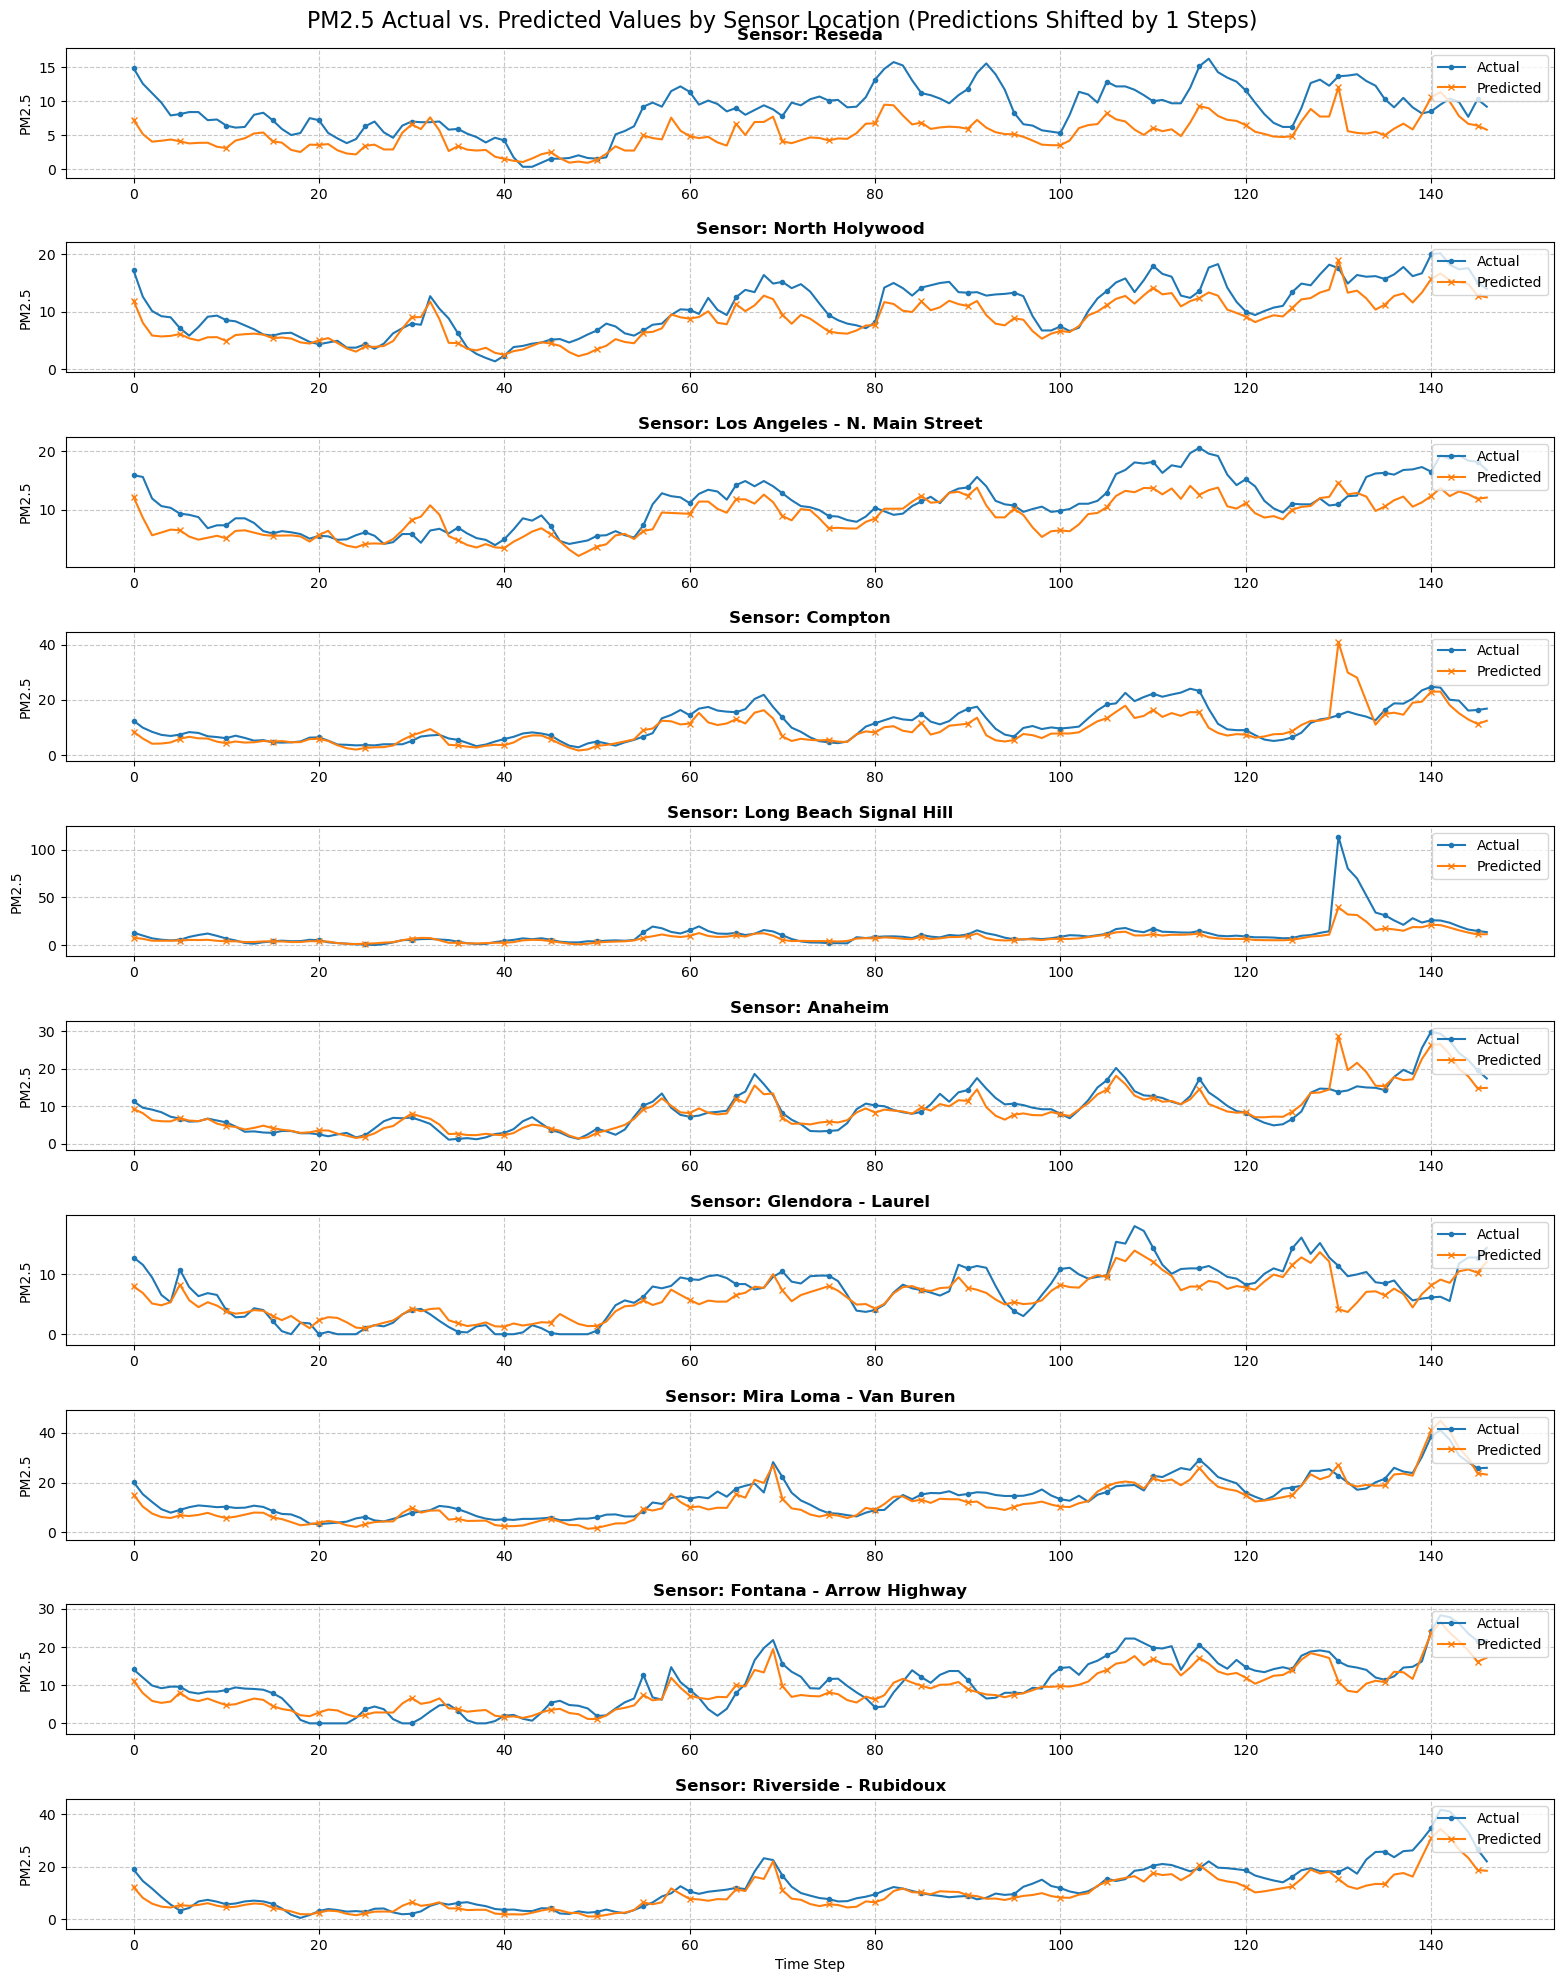


6. Printing detailed metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 4.60
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 43.56%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 3.53
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 23.40%

Frame 2 (Hour 2) All Locations - Raw RMSE: 2.60
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 20.95%

Frame 3 (Hour 3) All Locations - Raw RMSE: 2.93
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 28.91%

Frame 4 (Hour 4) All Locations - Raw RMSE: 3.30
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 38.93%

Frame 5 (Hour 5) All Locations - Raw RMSE: 2.72
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 36.36%

Frame 6 (Hour 6) All Locations - Raw RMSE: 2.98
Frame 6 (Hour 6) All L

In [26]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Get sensor names
if hasattr(airnow_data, 'sensor_names') and airnow_data.sensor_names is not None:
    sensor_names = airnow_data.sensor_names
else:
    sensor_names = list(airnow_data.air_sens_loc.keys())

print(f"\nSensors in {EXPERIMENT_NAME}: {sensor_names}")

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_actual, sensor_names, sample_idx=8)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_actual)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_actual, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, y_actual, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, y_actual, sensor_names, shift_pred=1)

print("\n6. Printing detailed metrics...")
print_metrics(y_pred, y_actual, sensor_names)